.

###### keywords

- sequence transduction model: 입력 시퀀스를 출력 시퀀스로 변환하는 모형(speech-to-text, text-to-speech, machine translation, protein secondary structure prediction)

- self-attention

- residual connection: 이전 레이어의 입력이 현재 레이어의 출력과 더해지는 연결 형태로서, 이하 논문의 figure2. 참고 (Wu, S., Zhong, S., & Liu, Y. (2017). Deep residual learning for image steganalysis. Multimedia Tools and Applications, 1–17. https://doi.org/10.1007/s11042-017-4440-4
 

지금까지 시퀀스 데이터를 변환하는 모형(sequence transduction model)들은 대부분 RNN이나 CNN과 인코더, 디코더 구조를 갖고 있었다. 최근에는 여기에 어텐션을 추가해서 성능을 높이는 시도가 있었다. 이 논문에서는 RNN과 CNN을 사용하지 않고 어텐션만으로 시퀀스 데이터를 처리하는 'Transformer'라는 모델을 소개한다. 구조적인 특징을 뿐만아니라 성능면에서도 기존의 방법들보다 우수한 결과를 확인할 수 있었다.

모델 구조는 

# Abstract

# 1. Introduction

# 2. Background

# 3. Model Architecture

### 3.1 Encoder and Decoder Stacks

- Encoder 레이어 하나는 'multi-head self-attention mechanism'과 'point-wise fully connected feed-forward network'라는 서브 레이어로 구성된다. 두 서브 레이어 사이에는 resudial connection과 layer normalization이 사용된다.

- Decoder는 encoder의 두 서브 레이어와 함께 masked-head attention이 사용된다.

### 3.2 Attention

- attention function: Query, Key, Value, output으로 구성된다.(scaled dot-product attention)

###### 3.2.1 Scaled Dot-Product Attention

###### 3.2.2 Multi-Head Attention

###### 3.2.3 Applications of Attention in our Model

### 3.3 Position-wise Feed-Forward Networks

 ..

### 3.4 Embeddings and Softmax

### 3.5 Positional Encoding

참고 논문: Gehring, J., Auli, M., Grangier, D., Yarats, D., & Dauphin, Y. N. (2017). Convolutional Sequence to Sequence Learning. https://doi.org/10.1002/nt.2620030507

# 4. Why Self-Attention

# 5. Training

### 5.1 Training Data and Batching

### 5.2 Hardware and Schedule

### 5.3 Optimizer

### 5.4 Regularization

# 6. Results

### 6.1 Machine Translation

### 6.2 Model Variations

### 6.3 English Constituency Parsing

# 7. Conclusion

###### Implementation(pytorch)

In [1]:
import time
import math
import copy

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# All

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

### Common parts

###### class Generator

Generator는 디코더를 지난 512개 출력값을 Linear 레이어와 Softmax를 통과시켜 '단어장의 단어' 각각에 대한 확률로 바꿔주는 레이어이다.

In [4]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

###### def clones

clones함수는 레이어의 (deepcopy)복제본을 만들때 사용된다.

In [5]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

###### class LayerNorm

LayerNorm은 레이어 출력값을 normalize하는 역할을 하며, class SublayerConnection에 사용된다.
$$\text{LayerNorm}(\cdot)$$

In [6]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

###### class SublayerConnection

sublayer는 multi-head (self) attention과 point-wise feed-forward network으로 두가지가 있다. 두가지 다른 sublayer를 표현하기 위해 forward 함수에서는 각 sublayer가 하는 일을 함수 인자(sublayer)로 받아 아래와 같은 일을 한다. (원 논문에 $\text{LayerNorm}(x + \text{Sublayer}(x))$라고 나온 것과는 구현이 조금 다르다.) (dropout이 기본적으로 포함됨)

$$x + \text{Sublayer}(\text{LayerNorm}(x))$$

In [7]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

### Encoder

Encoder는 6개의 EncoderLayer를 중첩한걸 의미한다.

In [8]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

EncoderLayer는 아래 2개의 sublayer로 구성된다.
- 'Position wise Feed-Forward Network'(feed_forward)
- 'Multi-Head Self-Attention'(self_attn)

In [9]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


### Decoder

아래의 Decoder는 6개의 DecoderLayer를 중첩한걸 의미한다. 

In [10]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

DecoderLayer는 아래 3개의 sublayer로 구성된다.
- 'Position wise Feed-Forward Network'(feed_forward)
- 'Multi-Head Self-Attention'(src_attn)
- 'Masked Multi-Head Self-Attention'(self_attn)

In [11]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

### Masking

'Attention is all you need'라는 문장을 한국어로 번역(네가 필요한건 어텐션 뿐이야)한다고 할 때, 첫 번역 단어로 '네가'가 나올 때 정답(한국어 번역문)을 참고할 수는 없다. 다음으로 '필요한건'을 다음 번역 단어로 내놓을 때에는 앞서 출력인 '네가'만을 참고해야 한다. 즉 현재($i$번째) 단어를 출력할 때에는 $i-1$번째까지의 정답만을 참고할 수 있다.

RNN등을 사용할 때에는 이런 순서가 autoregression구조로 자연스럽게 반영되는데, CNN이나 이 논문의 Transformer에서는 출력 단어의 embedding을 한꺼번에 생성하기 때문에 커닝을 막기 위해서 masking이란걸 도입한다. 즉 학습시 정답지를 모두 참고하는걸 막기 위해 $i$번째 단어를 예측할 때에는 $i-1$번째 target embedding까지만 참고할 수 있게 하는 것이다.

In [12]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [13]:
# test
attn_shape = (1, 5, 5)
np.triu(np.ones(attn_shape), 1)

array([[[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]])

In [14]:
torch.from_numpy(np.triu(np.ones(attn_shape), 1)) == 0

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)

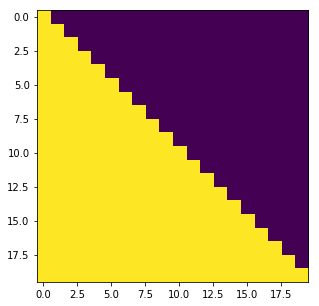

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### Attention

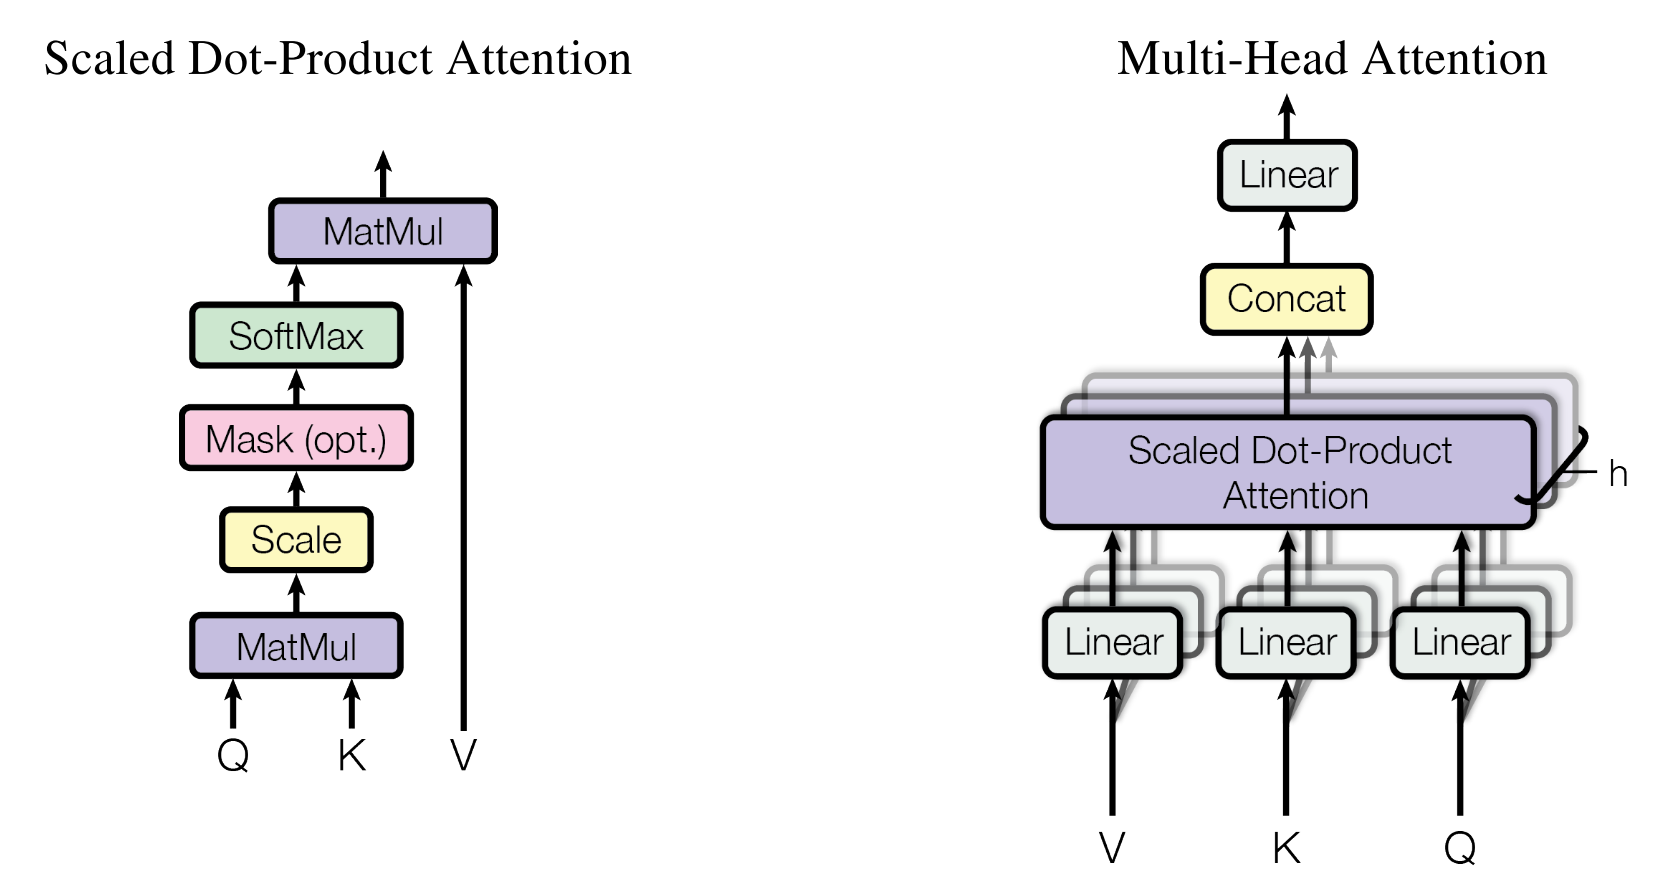

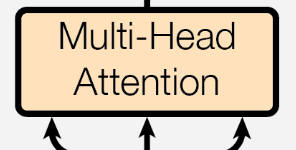

아주 간단히 말하자면 '과거 정보'($V=K$)중 '현재 정보'($Q$)와 연관성($\text{softmax}(\frac{Q K^\intercal}{\sqrt{d_k}})$)이 높은 정보를 사용한다는 아이디어다. (https://distill.pub/2016/augmented-rnns/ 의 Neural Tuning Machines 섹션에 나오는 그림을 참고하기 바람)

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^\intercal}{\sqrt{d_k}}) V$$

In [16]:
def attention(query, key, value, mask=None, dropout=None):
    """Compute 'Scaled Dot Product Attention'"""
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)  # Fills elements of tensor with value where mask is one.
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [17]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """Take in model size and number of heads."""
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """Implements Figure 2"""
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

- batch size = 30, 한번에 처리할 문장 수
- 문장당 토큰($\simeq$단어) 수 = 10
- $h = 8$, head 수, $Q, K, V$를 몇가지로 projection하는지를 의미
- $d_k = d_v =  64$, 각각 $K$와 $V$의 차원으로서 원래 $d_\text{model}$차원 벡터가 $d_\text{model}/ h$로 줄어든 형태이다. 이후 다시 각 head의 attention을 concat해서 $d_\text{model}$차원 벡터가 된다.
- $d_\text{model} = h\cdot d_k = 512$, 각 단어를 $d_\text{model}$차원 벡터로 embedding하며, 네트워크의 sublayer를 지나는 vector의 차원이 모두 $d_\text{model}$로 동일하다. 

예를들어 위와 같은 설정이라면 $Q \in \mathbb{R}^{30 \times 10 \times 512}, K \in \mathbb{R}^{30 \times 10 \times 512},  V \in \mathbb{R}^{30 \times 10 \times 512}$이고, projection을 위해 8개의 feed-forward layer를 통해 $512/h$ 차원으로 축소된 tensor를 얻는다. 즉 $QW^Q_i \in \mathbb{R}^{30 \times 10 \times 64}, KW^K_i \in \mathbb{R}^{30 \times 10 \times 64}, VW^V_i \in \mathbb{R}^{30 \times 10 \times 64}$ 이다.

$$\begin{align}
[QW^Q_1, KW^K_1, VW^V_1] &= \text{LinearProjecter}_1(Q, K, V) \\
[QW^Q_2, KW^K_2, VW^V_2] &= \text{LinearProjecter}_2(Q, K, V) \\
&\vdots \\
[QW^Q_8, KW^K_8, VW^V_8] &= \text{LinearProjecter}_8(Q, K, V) \\
\end{align}$$

8개 쌍의 $[QW^Q_i, KW^K_i, VW^V_i]$를 각각 $\text{Attention}=\text{softmax}\big( \frac{QW^Q_i (KW^K_i)^\intercal}{\sqrt{d_k}} \big) VW^V_i$에 통과시키면 8개의 head($\in \mathbb{R}^{30 \times 10 \times 64}$)를 얻는다. 

$$\begin{align}
\text{head_1} &= \text{Attention}(QW^Q_1, KW^K_1, VW^V_1) \\
\text{head_2} &= \text{Attention}(QW^Q_2, KW^K_2, VW^V_2) \\
&\vdots\\
\text{head_8} &= \text{Attention}(QW^Q_8, KW^K_8, VW^V_8) \\
\end{align}$$

8개의 head를 모두 concat한 후 다시 feed-forward layer를 통과시키면 MultiHeadAttention의 최종 출력을 얻는다. ($\text{MultiHead(Q, K, V)} \in \mathbb{R}^{30 \times 10 \times 512}$)

$$\begin{align}
\text{MultiHead(Q, K, V)} &= \text{Concat}(\text{head}_1, \text{head}_2, \cdots, \text{head}_8) W^O
\end{align}$$

다만 harvardnlp의 코드에서는 8개의 $\text{LinearProjector}$를 입력노드와 출력 노드 모두 512개인 feed-forward layer를 사용하고, 512개의 출력 노드는 8개로 나눠 $QW^Q \in \mathbb{R}^{30 \times 8 \times 10 \times 64}, KW^K \in \mathbb{R}^{30 \times 8 \times 10 \times 64}, VW^V \in \mathbb{R}^{30 \times 8 \times 10 \times 64}$ 가 되도록 구현하고 있다.

### Position-wise Feed-Forward Networks

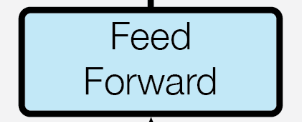

Figure1의 'Feed Forward'라고 표기된 파란색 박스는 노드 수가 512(=$d_{model}$)인 입력 레이어와, 노드 수가 2048개이고 relu activation을 사용하는 히든 레이어가 하나와, 노드 수가 512개인 출력 레이어로 구성된 feed-forward network를 의미한다.

그런데 이 네트워크에 각 단어(token)에 대한 embedding 벡터가 입력으로 사용되므로, 문장을 구성하는 서로 다른 토큰에 동일한 네트워크가 사용된다. 이렇게 토큰 단위로 동일한 네트워크를 사용하기 때문에 'Position-wise' feed-forward networks라 부르고 있다.

In [18]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(in_features=d_model, out_features=d_ff)
        self.w_2 = nn.Linear(in_features=d_ff, out_features=d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


In [19]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding

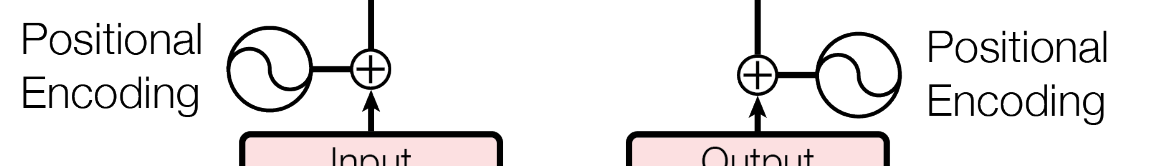

In [20]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # for even index of d_model
        pe[:, 1::2] = torch.cos(position * div_term)  # for odd index of d_model
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)


예를들어 30개 단어로 구성된 문장이 있고, 각 단어를 512차원의 embedding으로 표현한다면, 이 문장을 30x512의 행렬로 표현할 수 있다. 행렬 그 자체는 어떤 단어가 먼저 나오는지 늦게 나오는지에 대한 순서 정보가 포함되어 있지 않다. embedding에 이 순서 정보를 추가하기 위해 embedding의 각 차원마다 sin/cos 신호를 더해준다. 아래 그림에서 하나의 sin/cos 곡선이 30x1 벡터이고 embedding의 특정 차원에 더해지는 것이다. 그리고 각 차원마다 sin/cos의 주기가 달라지며, 짝수번째 차원에는 sin wave가, 홀수번째 차원에는 cos wave가 더해진다.

각 단어를 길이가 $d_{\text{model}}$인 Embedding 벡터로 변환하고, 여기에 동일한 길이의 벡터인 Positional encoding을 더한 후, 이 벡터를 인코더의 입력으로 사용한다. 출력 단어를 디코더에 입력할 때도 동일한 방식을 적용한다. (pos는 문장에서 각 단어의 위치를 의미한다. $i$는 embedding의 dimension index를 의미한다.

$$\begin{align}
PE_{(pos, 2i)} &= \sin(pos / 10000^{2i/d_{\text{model}}}) \\
PE_{(pos, 2i+1)} &= \cos(pos / 10000^{2i/d_{\text{model}}})
\end{align}$$

> $$\text{div_term} = \frac{1}{10000^{\frac{2i}{d_{\text{model}}}}}$$

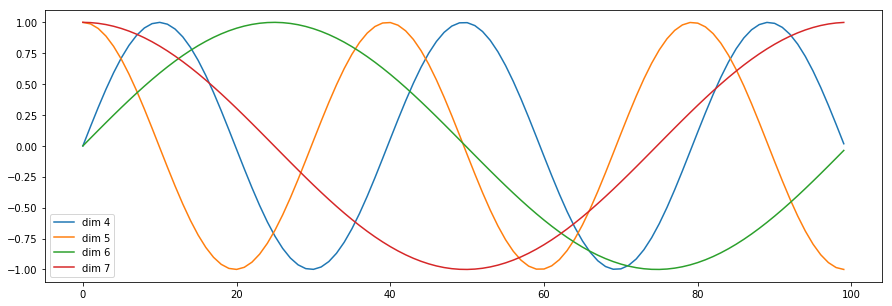

In [21]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)  #  embedding size = 20
y = pe.forward(Variable(torch.zeros(1, 100, 20)))  # sequence length = 100
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

> comment in the function 'get_timing_signal_1d' of common_attention.py - tensor2tensor
- Each channel of the input Tensor is incremented by a sinusoid of a different frequency and phase.
- This allows attention to learn to use absolute and relative positions. Timing signals should be added to some precursors of both the query and the  memory inputs to attention.
- The use of relative position is possible because sin(x+y) and cos(x+y) can be expressed in terms of y, sin(x) and cos(x).
-  In particular, we use a geometric sequence of timescales starting with min_timescale and ending with max_timescale.  The number of different timescales is equal to channels / 2. For each timescale, we generate the two sinusoidal signals sin(timestep/timescale) and cos(timestep/timescale).  All of these sinusoids are concatenated in the channels dimension.

### Assembling blocks

In [22]:
def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    """Helper: Construct a model from hyperparameters."""
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # nn.init.xavier_uniform(p)
            nn.init.xavier_uniform_(p)  # fixed by kdw
    return model

In [23]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [24]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            # print("Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.ntokens, tokens / elapsed))
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f"
                  % (i, loss / batch.ntokens.type(torch.FloatTensor), tokens.type(torch.FloatTensor) / elapsed))
            start = time.time()
            tokens = 0
    # return total_loss / total_tokens
    return total_loss / total_tokens.type(torch.FloatTensor)  # fixed by kdw

In [25]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [26]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [27]:
class LabelSmoothing(nn.Module):
    """Implement label smoothing."""

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        # self.criterion = nn.KLDivLoss(size_average=False)
        self.criterion = nn.KLDivLoss(reduction='sum')  # fixed by kdw
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 1:  # fixed 0 to 1 by kew.
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


crit = LabelSmoothing(5, 0, 0.1)

In [28]:
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    # print(predict)
    return crit(Variable(predict.log()),
                Variable(torch.LongTensor([1]))).data[0]

### A First Example

In [ ]:
"""
A Simple Example
"""


def data_gen(V, batch, nbatches):
    """Generate random data for a src-tgt copy task."""
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)


class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        norm = norm.type(torch.FloatTensor)  # added by kdw
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        # return loss.data[0] * norm
        return loss.data.item() * norm


# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V=V, batch=30, nbatches=20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V=V, batch=30, nbatches=5), model,
                    SimpleLossCompute(model.generator, criterion, None)))

/Users/notyetend/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 3.000408 Tokens per Sec: 744.156433


In [29]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

NameError: name 'model' is not defined

### A Real World Example

(skip)

### Attention Visualization

pre-trained model을 불러와서 attention을 시각화해보겠습니다.

In [19]:
import os
os.getcwd()

'/Users/notyetend/playground/toys/pg/post_queue'

!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

In [30]:
model, SRC, TGT = torch.load("en-de-model.pt")

/Users/notyetend/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/notyetend/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/notyetend/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code 

In [31]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 


Encoder Layer 2


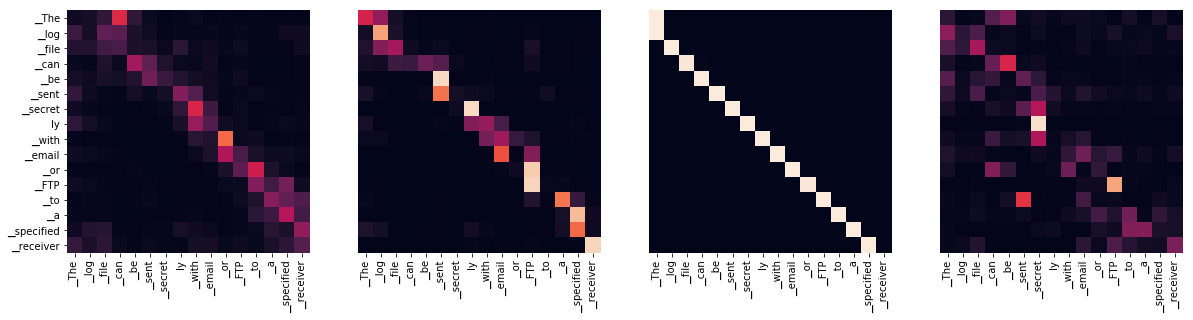

Encoder Layer 4


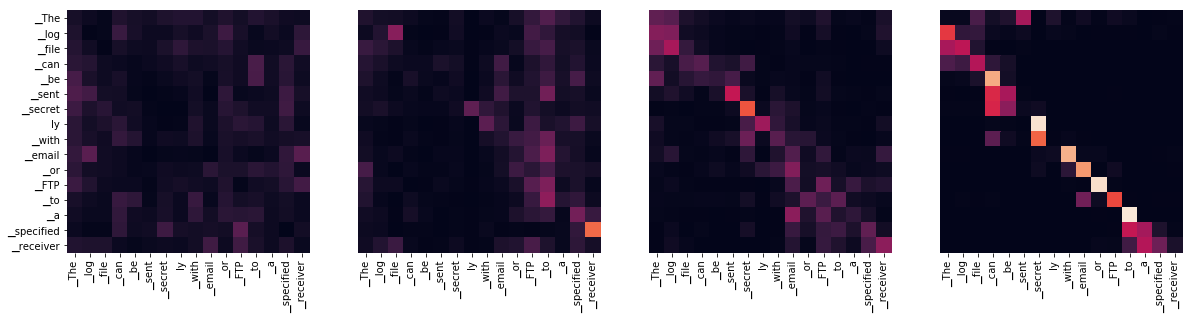

Encoder Layer 6


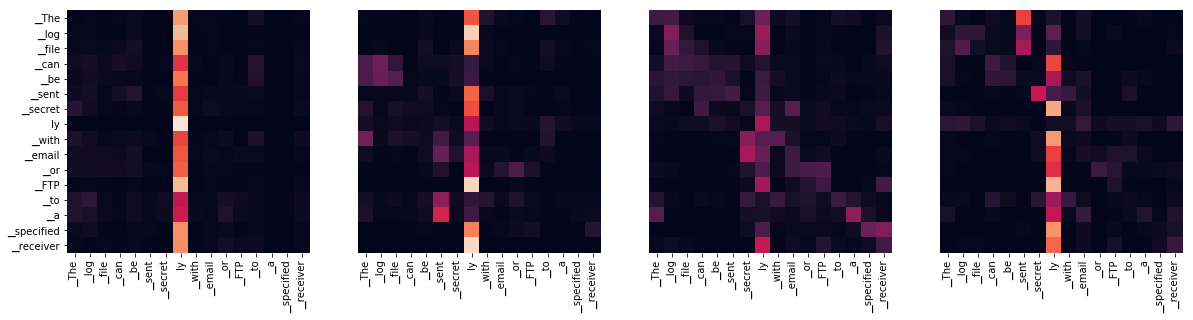

Decoder Self Layer 2


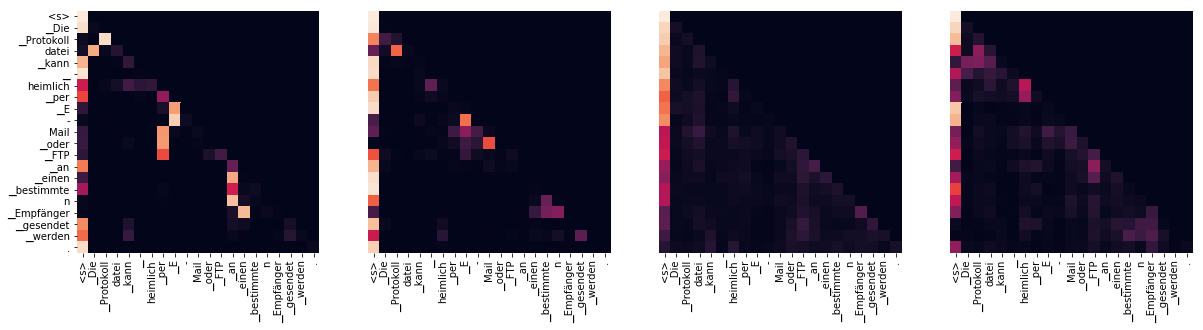

Decoder Src Layer 2


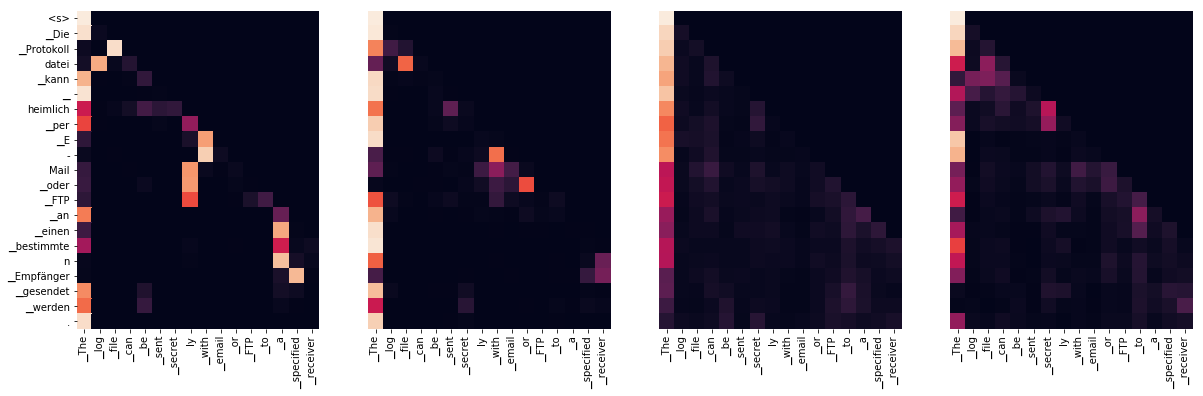

Decoder Self Layer 4


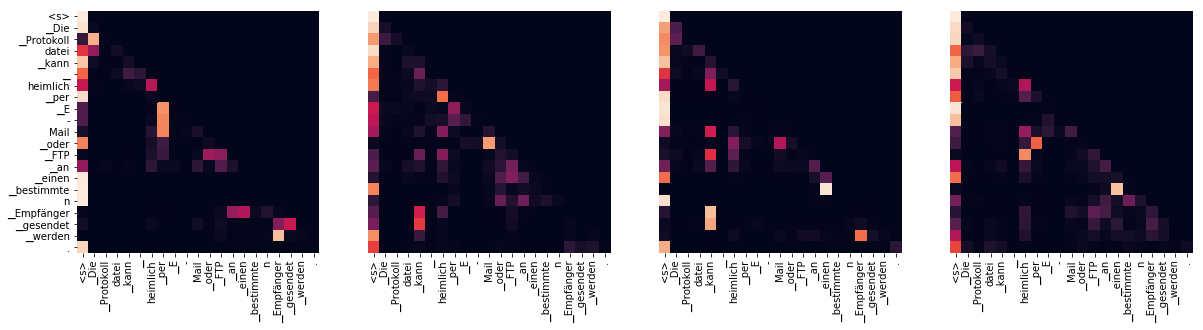

Decoder Src Layer 4


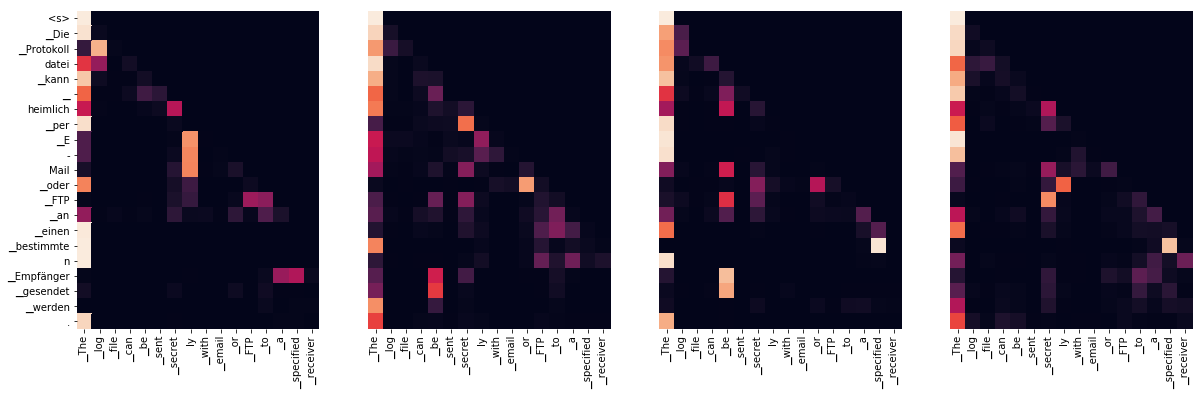

Decoder Self Layer 6


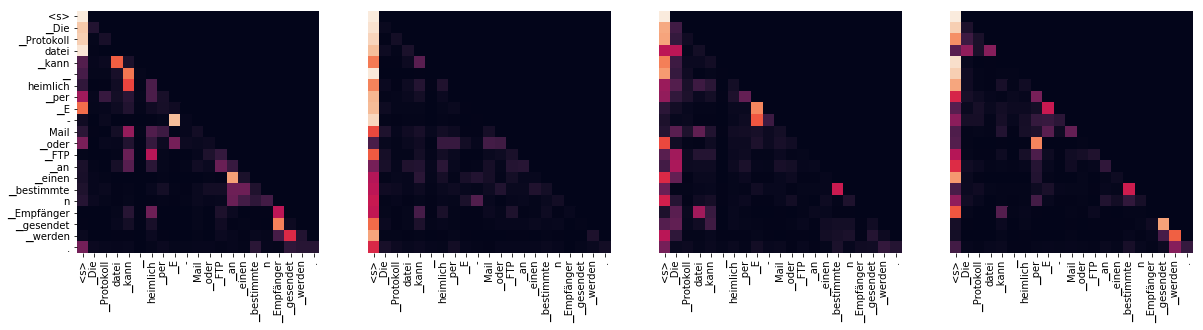

Decoder Src Layer 6


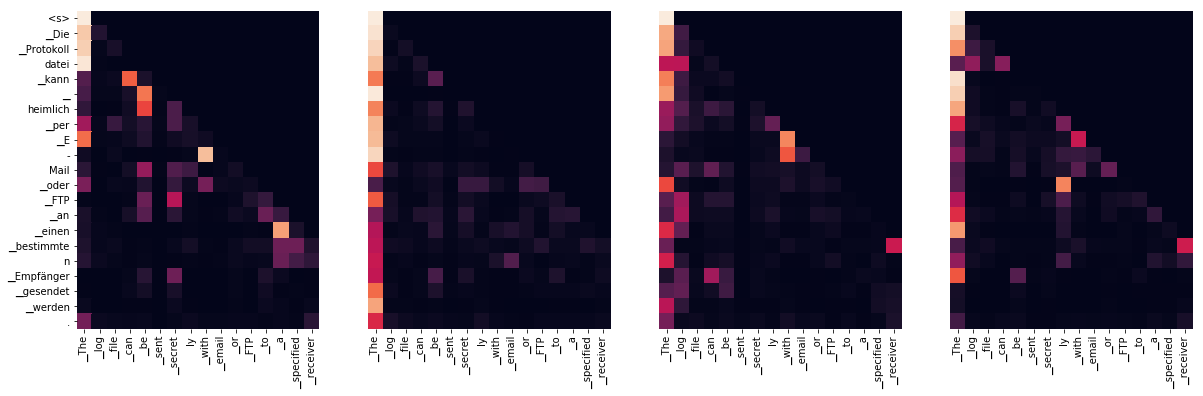

In [33]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    import seaborn
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

.

### 참고자료

- original paper: https://arxiv.org/abs/1706.03762

- video: 
 - Łukasz Kaiser: https://www.youtube.com/watch?v=rBCqOTEfxvg
 - Yannic Kilcher: https://www.youtube.com/watch?v=iDulhoQ2pro

- post about residual networks
 - https://en.wikipedia.org/wiki/Residual_neural_network

- post about attention mechanism
 - https://www.quora.com/How-does-an-attention-mechanism-work-in-deep-learning
 - http://freesearch.pe.kr/archives/4876?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+gogamza+%28from+__future__+import+dream%29#easy-footnote-2-4876
 - https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
 
- post about transformer
 - https://distill.pub/2016/augmented-rnns/
 - http://jalammar.github.io/illustrated-transformer/
 - https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
 - http://nlp.seas.harvard.edu/2018/04/01/attention.html
 - http://nlp.seas.harvard.edu/2018/04/03/attention.html
 - https://ricardokleinklein.github.io/2017/11/16/Attention-is-all-you-need.html
 
- Implementation(tensorflow)
 - https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/transformer.py
 - https://github.com/Kyubyong/transformer
 - https://github.com/ufal/neuralmonkey/blob/master/neuralmonkey/encoders/transformer.py
 - https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/transformer.py
 - https://github.com/lilianweng/transformer-tensorflow
 
- Implementation(pytorch)
 - https://github.com/jadore801120/attention-is-all-you-need-pytorch
 - https://github.com/harvardnlp/annotated-transformer

- Implementation(keras)
 - https://github.com/Lsdefine/attention-is-all-you-need-keras

Thank you.